In [1]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from gurobipy import *
import multiprocessing

import random
import math
from random import choice
from random import sample
import numpy.random as rn

from collections import Counter


from sympy import *

#from sklearn.metrics import mean_squared_error

# GUROBI MODEL

In [2]:
def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

# GRAPH CREATORS 

In [3]:

def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("Black")
        else:
            node_colors.append("Silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

def create_data(n,num):
    
    k = 0.5
    
    if num==1:
        G = nx.grid_2d_graph(n,n)
    if num==2:
        G = nx.triangular_lattice_graph(n,n)
    if num==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

def Creation(n,choice):
    k = 0.5
    
    if choice==1:
        G = nx.grid_2d_graph(n,n)
    if choice==2:
        G = nx.triangular_lattice_graph(n,n)
    if choice==3:
        G= nx.path_graph(n)

    N = len(G.nodes())
    
    m = random.randrange(0,N)
    n = N-m

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    #pos = nx.spring_layout(G, weight=None)
    #nx.set_node_attributes(G,pos,'pos')
    
    return G

# PLOT

In [19]:
def Plot2D(G,pos,size=5):

    H0 = G.copy()
    #pos =nx.get_node_attributes(H0,'pos')
    node_colors=nx.get_node_attributes(H0,'color')

    edge_colors = []
    for n1,n2,val in H0.edges.data():

        #print(n1,n2)
        if H0.nodes[n1]['color']==H0.nodes[n2]['color']:

            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Black":
                edge_colors.append("red")
                #negative +=1
            if H0.nodes[n1]['color'] ==H0.nodes[n2]['color'] == "Silver":
                edge_colors.append("green")
                #positive +=1
        else:
                edge_colors.append("lightgrey")

    attr2 = {}
    for edge,color in zip(H0.edges(),edge_colors):

        #print(edge,color)
        attr2[edge]=color

    nx.set_edge_attributes(H0, attr2, 'edge_color')
    
    edge_colors=nx.get_edge_attributes(H0,'edge_color')
        
    #pos = nx.spring_layout(G, weight=None)
    
    options = {"node_size": 100, "alpha": 0.6}

    fig, ax = plt.subplots(figsize=(size,size))
    nx.draw(H0,pos,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=False, width = 5.0,**options)
    
    plt.savefig('figure1.png')

# FRUSTRATION

In [5]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

def color_of_frustration(H):
    
    positive=0
    negative=0

    for n1,n2,val in H.edges.data():
        
        G = H.copy() 
        color1 = G.nodes[n1]['color']
        color2 = G.nodes[n2]['color']
        if color1 == color2 or color2==color1:
            #print("true")
            if color1 == color2 == "Black":
                negative +=1
            if color1 == color2 == "Silver":
                positive +=1
                
    return positive,negative

def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    
    if p>n:
        return int(np.sqrt((p-n)**2))
    else:
        return int(np.sqrt((n-p)**2))

# ANNEALING

In [6]:
def random_neighbour(G):
 
    H = G.copy()
    
    random_node = sample(H.nodes(),1)[0]
    
    chosen_color = H.nodes[random_node]['color']
    if chosen_color == "Silver":
        H.nodes[random_node]['color'] = "Black"
    else:
        H.nodes[random_node]['color'] = "Silver"
    
    return H

def target_delta(state, target):
    
    new = calculate_delta(state)
    
    mse = np.abs(target-new)

    return mse

def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p

def temperature(fraction):
    
    value = max(0.01, min(1, 1 - fraction))
    return value

def Annealing(G0,target, maxsteps=1000):

    
    state = G0.copy()
    cost_funct = target_delta
    
    cost = cost_funct(state,target)
    
    if cost == 0:
        return state
    
    for step in range(maxsteps):
        
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        
        new_state = random_neighbour(state)
        
        new_cost = cost_funct(new_state,target)
        
        if acceptance_probability(cost, new_cost, T) > rn.random():
            
            state, cost = new_state, new_cost
            if cost == 0:
                return state    
    return state

# QUENCHING PROCESS

In [7]:
def Quench_Process(Gs):

    total=[]
    Delta = []
    for i in tqdm(range(len(Gs))):
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        deltas = []
        deltas.append(calculate_delta(H))
        
        G = H.copy()
        for k in range(1,500):
            
            nx.algorithms.connected_double_edge_swap(G, nswap=1)
            
            fr = frustration_count(G)
            res.append(fr)
            deltas.append(calculate_delta(G))

        total.append(res) 
        Delta.append(deltas)
        
    return np.array(total),np.array(Delta)

def Get_Probabilites(data,Edge,repeat):

    p_t=[]
    for t in range(len(data[0])):

        prob=[]
        for i in range(0,Edge):
            prob.append(np.count_nonzero(np.array(data[:,t]) == i))
        p_t.append(np.array(prob)/repeat)

    P_t = np.array(p_t)

    p_even=[]
    for l in P_t:
        p_even.append(l[::2])

    P_even = np.array(p_even)

    return P_t,P_even

def Get_Means(data):
    
    total = np.array(data)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))

    return np.array(final)

In [116]:
def Quench(Gs,timesteps=100):
    

    total=[]
    
    for g0 in tqdm(Gs):
    
        specific_avg = []
        for i in (range(timesteps)):

            H = g0.copy()

            res=[]
            res.append(frustration_count(H))

            G = H.copy()
            
            #d0  = calculate_delta(G)
            for k in (range(1,timesteps)):

                nx.algorithms.connected_double_edge_swap(G, nswap=1)
                #G = nx.random_reference(G,connectivity=True)
    
                res.append(frustration_count(G))
        
                #if calculate_delta(G) != d0:
                    #print("Greška")

            specific_avg.append(res)
        
        total.append(specific_avg) 
            
        
    return np.array(total)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# QUENCH

### n = 5

L =  180
f = 92 d = 22
p = 35 n = 57


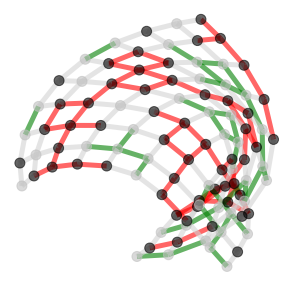

In [80]:
%matplotlib inline

G = Creation(10,1)
Plot2D(G,nx.spring_layout(G, weight=None),5)


######################################################################
edge_length = len(G.edges())
print("L = ",edge_length)
print("f =",frustration_count(G),"d =",calculate_delta(G))
p,n = color_of_frustration(G)
print("p =",p,"n =",n)
######################################################################

### Create N = 10000 graphs

In [100]:
Gs = []

for i in tqdm(range(10000)):
    
    g = Creation(10,1)
    
    if frustration_count(g) != calculate_delta(g):
        Gs.append(g)

100%|██████████| 10000/10000 [18:12<00:00,  9.15it/s]


In [101]:
avg = []
dic = {}
for index,gs in tqdm(enumerate(Gs)):
    
    f = frustration_count(gs)
    d = calculate_delta(gs)
    avg.append((f,d))
    
    string = "("+str(f)+","+str(d)+")"

    
    if string in dic:
        dic[string].append(index)
    else:
        dic[string] = [index]
    
AVG = Counter(avg)
print(AVG)

8646it [15:34,  9.25it/s]

Counter({(149, 147): 31, (154, 152): 30, (150, 148): 25, (156, 154): 25, (152, 150): 24, (159, 157): 24, (160, 158): 23, (157, 155): 23, (138, 130): 23, (146, 144): 22, (153, 151): 22, (155, 153): 22, (151, 149): 20, (161, 159): 19, (148, 146): 19, (143, 141): 19, (141, 137): 19, (125, 115): 18, (144, 140): 18, (141, 135): 18, (140, 136): 18, (167, 165): 18, (163, 161): 18, (123, 109): 17, (124, 110): 17, (151, 147): 17, (106, 84): 17, (147, 143): 17, (131, 119): 16, (115, 97): 16, (127, 117): 16, (140, 132): 16, (146, 142): 16, (99, 61): 16, (143, 137): 16, (109, 81): 16, (126, 114): 16, (166, 164): 16, (143, 139): 15, (134, 128): 15, (123, 107): 15, (131, 121): 15, (102, 70): 15, (139, 131): 15, (129, 119): 15, (139, 133): 15, (141, 139): 15, (142, 138): 15, (145, 143): 15, (129, 123): 15, (162, 160): 15, (137, 129): 14, (136, 128): 14, (111, 87): 14, (121, 109): 14, (127, 115): 14, (135, 129): 14, (131, 125): 14, (124, 114): 14, (137, 133): 14, (97, 63): 14, (144, 138): 14, (130, 12

In [107]:
l = 102
j = 62

string = "("+str(l)+","+str(j)+")"
indexs  = dic[string]
print(indexs)

accessed_mapping = map(Gs.__getitem__, indexs)

selected_graphs = list(accessed_mapping)

print(selected_graphs)

[453, 2208, 2226, 2338, 2361, 4111, 4504, 5292, 7280, 8055]
[<networkx.classes.graph.Graph object at 0x7f8574cb2520>, <networkx.classes.graph.Graph object at 0x7f855bf31e80>, <networkx.classes.graph.Graph object at 0x7f855ba1a460>, <networkx.classes.graph.Graph object at 0x7f855aad6070>, <networkx.classes.graph.Graph object at 0x7f855aad6940>, <networkx.classes.graph.Graph object at 0x7f854d14b490>, <networkx.classes.graph.Graph object at 0x7f854a2c3a00>, <networkx.classes.graph.Graph object at 0x7f8543fde5b0>, <networkx.classes.graph.Graph object at 0x7f8534a76970>, <networkx.classes.graph.Graph object at 0x7f852e5b6250>]


In [156]:
for i in selected_graphs:
    print(frustration_count(i),calculate_delta(i))

102 62
102 62
102 62
102 62
102 62
102 62
102 62
102 62
102 62
102 62


# Quench

In [147]:
timesteps = 1000

data = Quench(selected_graphs,timesteps)

100%|██████████| 10/10 [1:33:37<00:00, 561.75s/it]


In [159]:
np.save("dataL180f102d62.npy",data)

# Extract Probabilites and Expected Values

In [148]:
def Get_Probabilites(data,Edge,repeat):
    
    avg_P_t = []
    for a in data:
        p_t=[]
        for t in range(len(a[0])):

            prob=[]
            for i in range(0,Edge):
                prob.append(np.count_nonzero(np.array(a[:,t]) == i))
            p_t.append(np.array(prob)/repeat)

        P_t = np.array(p_t)
        avg_P_t.append(P_t)

    return np.array(avg_P_t)


## Probabilites

In [149]:
edge = edge_length

print(edge,timesteps)

avg_P_t = Get_Probabilites(data,edge,timesteps)

print(np.shape(avg_P_t))

avg_P = []
for t in range(timesteps):
    avg_p = []
    for i in range(edge):
        avg_p.append((np.mean(avg_P_t[:,t,i]),np.std(avg_P_t[:,t,i])))
    avg_P.append(avg_p)
    
p_even=[]
for l in avg_P:
    p_even.append(l[::2])

P_even = np.array(p_even)

180 1000
(10, 1000, 180)


## Expected Value

In [150]:
def Get_Means(data):
    
    total = np.array(data)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))

    return np.array(final)

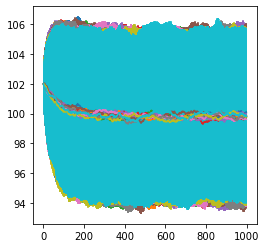

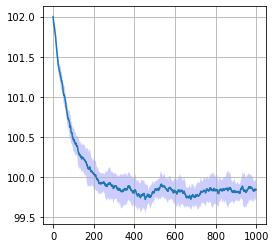

In [151]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4,4))

Means = []
for k in range(len(data)):

    means_k = Get_Means(data[k])

    ax.errorbar([i for i in range(len(means_k))],[i for i,j in means_k],[j for i,j in means_k])   
    
    Means.append([i for i,j in means_k])

#ax.set_ylim(0,edge)
plt.show()

MEANS = Get_Means(Means)


####################################################################################################
fig, ax = plt.subplots(figsize=(4,4))
#ax.errorbar([i for i in range(len(MEANS))],[i for i,j in MEANS],[j for i,j in MEANS])
x  = np.array([i for i in range(len(MEANS))])
y = np.array([i for i,j in MEANS])
y_err = np.array([j for i,j in MEANS])

ax.plot(x,y)
ax.fill_between(x, y - y_err, y + y_err,facecolor="blue",alpha=0.2)
#ax.set_ylim(0,edge)
ax.grid()
plt.show()
####################################################################################################

# ANALYTICS

In [152]:
def analytical(L,f0,d0):

    edge = L

    f0 = f0

    t = symbols('t')
    x = symbols('x', cls=Function)
    L = symbols('L', real=True)
    d = symbols('d', real=True)

    gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

    l=edge
    k=d0
    sol = gsol.subs({L: l,d:k})
    lmbd_sol = lambdify(t, sol.rhs)
    
    return lmbd_sol

180


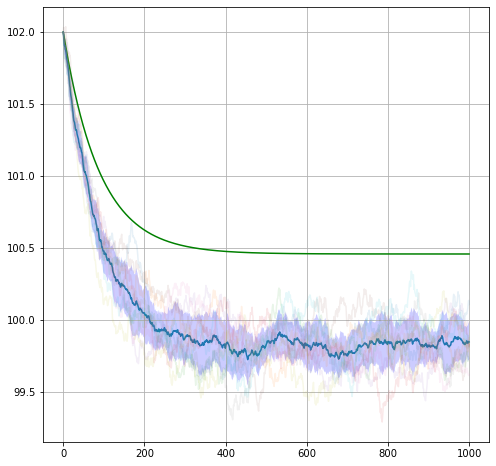

In [163]:
%matplotlib inline

print(edge)

f0 = 102
d0 = 62

lmbd_sol = analytical(edge,f0,d0)
    
xs = np.linspace(0,timesteps-1,timesteps)
#print(np.round(xs))
y_predicted= lmbd_sol(xs)
    
    
    
    
#####################################
fig, ax = plt.subplots(figsize=(8,8))


#####################################
for k in range(len(data)):

    means_k = Get_Means(data[k])

    ax.errorbar([i for i in range(len(means_k))],[i for i,j in means_k],alpha=0.1)   

#####################################

ax.plot(xs,y_predicted,color="green")

#"""
ax.plot([i for i in range(len(MEANS))],[i for i,j in MEANS])
ax.fill_between([i for i in range(len(MEANS))], 
                np.array([i for i,j in MEANS]) - np.array([j for i,j in MEANS]), 
                np.array([i for i,j in MEANS]) + np.array([j for i,j in MEANS]),facecolor="blue",alpha=0.2)
#"""
#ax.set_ylim(0,edge_length)
ax.grid()
plt.show()
#####################################

In [146]:
import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

matplotlib.use('TkAgg')

root = Tk.Tk()
root.wm_title("Embedding in TK")
fig = plt.Figure(figsize=(15,10))
canvas = FigureCanvasTkAgg(fig, root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


###############################################

ax=fig.add_subplot(121)
fig.subplots_adjust(bottom=0.25)

#fig.suptitle('L='+str(l)+', d='+str(k), fontsize=16)

t=0

x = [i for i in range(len(avg_P[t]))]
y = np.array([i for i,j in avg_P[t]])
y_err = np.array([j for i,j in avg_P[t]])

#ax.errorbar(x,y,y_err,capsize=3)
#l12  = ax.fill_between(x, y - y_err, y + y_err,facecolor="blue",alpha=0.2)#, alpha=0.25)#, edgecolor="black")


x = [i*2+1 for i in range(len(P_even[t]))]
y = np.array([i for i,j in P_even[t]])
y_err = np.array([j for i,j in P_even[t]])

ax.errorbar(x,y,y_err,capsize=3)
l12  = ax.fill_between(x, y - y_err, y + y_err,facecolor="red",alpha=0.2)

#ax.plot([i for i in range(len(p_true))],p_true,color="red")
#ax.plot([i*2+1 for i in range(len(p_true[::2]))], p_true[::2],color="red")
#ax.scatter([i*2+1 for i in range(len(p_true[::2]))], p_true[::2],color="red")

ax.set_ylim(0,1)
#ax.set_xlim(300,450)
ax.set_xlabel("f")
ax.set_ylabel("P(f)")
ax.grid()

# INSET AXES

from mpl_toolkits.axes_grid.inset_locator import inset_axes

inset_axes = inset_axes(ax, width="30%",height=2.0,loc=1)
"""
inset_axes.plot([i for i in range(len(JS))],JS)
inset_axes.scatter(t,JS[t])
inset_axes.set_xscale('log')
inset_axes.set_ylim(0,1)
inset_axes.set_xlabel('t', fontsize=14)
inset_axes.set_ylabel('JSD(P||Q,t)', fontsize=14)
inset_axes.grid()
"""
#################################################################################################

ax2=fig.add_subplot(122)

ax2.errorbar([i for i in range(len(MEANS[:,0]))],MEANS[:,0],MEANS[:,1],alpha=0.1,color="blue")
ax2.plot([i for i in range(len(MEANS[:,0]))],MEANS[:,0],color="blue")
line2 = ax2.axvline(x=t,linestyle="-",color="red")
#line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

ax2.plot([i for i in range(len(y_predicted))],[i for i in y_predicted],linestyle="--",color="green")

ax2.set_xlabel("t")
ax2.set_ylabel("f(t)")
#ax2.set_ylim(0,L)
ax2.grid()

####################################################################################################
ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
s_time = Slider(ax_time, 'Time', 0, timesteps-1, valinit=0)

tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
###############################################

def update(val):
    
    ax.cla()
    ax.set_ylim(0,1)
    #ax.set_xlim(300,450)
    ax.set_xlabel("f")
    ax.set_ylabel("P(f)")
    ax.grid()

    value = int(s_time.val)
        
    x = [i for i in range(len(avg_P[value]))]
    y = np.array([i for i,j in avg_P[value]])
    y_err = np.array([j for i,j in avg_P[value]])
    
    x = [i*2+1 for i in range(len(P_even[value]))]
    y = np.array([i for i,j in P_even[value]])
    y_err = np.array([j for i,j in P_even[value]])
    
    ax.errorbar(x,y,y_err,capsize=3)
    ax.fill_between(x, y - y_err, y + y_err,facecolor="red",alpha=0.2)
    
    """
    inset_axes.cla()
    inset_axes.plot([i for i in range(len(JS))],JS)
    inset_axes.scatter(value,JS[value])
    inset_axes.set_xscale('log')
    inset_axes.set_ylim(0,1)
    inset_axes.set_xlabel('t', fontsize=14)
    inset_axes.set_ylabel('JSD(P||Q,t)', fontsize=14)
    inset_axes.grid()
    """
    
    
    
    line2.set_xdata(value)
    
    fig.canvas.draw_idle()

from tkinter import Button
Button(root, text="Quit", command=root.destroy).pack()
    
    
s_time.on_changed(update)

Tk.mainloop()

In [ ]:
from sympy import *


import random
import matplotlib
import tkinter as Tk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def Tkinter_Plot(data1,data2,data3,L,f0,d0):
    
    lmbd_sol = analytical(L,f0,d0)


    matplotlib.use('TkAgg')

    root = Tk.Tk()
    root.wm_title("Embedding in TK")
    fig = plt.Figure(figsize=(10,5))
    canvas = FigureCanvasTkAgg(fig, root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)


    ###############################################

    ax=fig.add_subplot(121)
    fig.subplots_adjust(bottom=0.25)

    fig.suptitle('L='+str(L)+', d='+str(d0), fontsize=16)

    t=0
    l11, = ax.plot([i for i in range(len(data1[t]))], data1[t])
    l12, = ax.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
    line = ax.axvline(x=data3[t,0],linestyle="--",color="green")
    ax.set_ylim(0,1)

    ax.set_xlabel("f")
    ax.set_ylabel("P(f)")
    ax.grid()

    ###############################################
    ax_time = fig.add_axes([0.12, 0.1, 0.78, 0.03])
    s_time = Slider(ax_time, 'Time', 0, len(data1)-1, valinit=0)

    tekstić = ax.text(0.05, 0.95, s_time.val, transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
    ###############################################

    ax2=fig.add_subplot(122)

    ax2.errorbar([i for i in range(len(data3[:,0]))],data3[:,0],data3[:,1],alpha=0.1,color="blue")
    ax2.plot([i for i in range(len(data3[:,0]))],data3[:,0],color="blue")
    line2 = ax2.axvline(x=t,linestyle="-",color="red")
    line3 = ax2.axhline(y=data3[t,0],linestyle="-",color="red")

    xs = np.linspace(0,len(data1),len(data1))
    ax2.plot(xs,lmbd_sol(xs),linestyle="--",color="green")


    ax2.set_xlabel("t")
    ax2.set_ylabel("f(t)")
    ax2.set_ylim(0,L)
    ax2.grid()


    ###############################################

    def update(val):

        value = int(s_time.val)

        l11.set_ydata(data1[value])
        l12.set_ydata(data2[value])
        line.set_xdata(data3[value,0])

        tekstić.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))#+"-> "+str(np.round(lmbd_sol(value),2)))

        line2.set_xdata(value)
        line3.set_ydata(data3[value,0])

        fig.canvas.draw_idle()

    from tkinter import Button
    Button(root, text="Quit", command=root.destroy).pack()


    s_time.on_changed(update)

    Tk.mainloop()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Stationary distribution